# Breakout Test 🎮🕹️


## Packages

In [1]:
#!pip install gym[atari]

In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt 
import time
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Activation, Convolution2D, Permute
from keras.optimizers import Adam

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Current directory setting

In [3]:
import os
if os.getcwd()[:8] == "/content" : 
    # Google Drive
    from google.colab import drive
    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive/Colab Notebooks/Atari')
    !ls
else :
    # Linux INSA
    save = "/home/villegas/Documents/projet_5gmm/Atari/save"
    os.chdir(save)

## Class Agent

In [4]:
class DQN_Breakout_Agent_Test:
    def __init__(self, weights_file):
        self.samples_frame_size = 4
        self.state_size = (self.samples_frame_size, 84, 74)
        self.action_size = 4
        self.model = self._build_model(weights_file)
        self.current_state = deque(maxlen=self.samples_frame_size) # processing batch of frames

    def _build_model(self, weights_file):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        # Permute change 4x84x74 to 84x74x4
        model.add(Permute((2, 3, 1), input_shape=self.state_size))
        model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(4))
        model.add(Activation('linear'))
        model.compile(loss='mse',optimizer=Adam(lr=0.00025))
        # Load weights file
        model.load_weights(weights_file)
        return model

    def act(self, state):
        batch_state = deque_to_batch(state)
        act_values = self.model.predict(batch_state) # Keras need a 1x4x84x74 batch
        return np.argmax(act_values[0])  # returns action ()
    
    # On initialise en écrasant tout     
    def init_current_state(self, frm):
        for i in range(self.samples_frame_size):
            self.current_state.append(frm)
        return self.current_state
    
    # update the 4 current batch frames
    def update_current_state(self, next_frame):
        self.current_state.append(next_frame)
        return self.current_state

## New fonctions

In [5]:
def preprocessing(img):
    """
    Gray-scale, reduce edges and down-sampling img to a 84×74 image
    """
    return np.mean(img, axis=2)[30:-12,6:-6][::2,::2].astype(np.uint8)

def reward_clipping(reward):
    """
    reward: negative -> -1; positive -> +1
    """
    return np.sign(reward)

def deque_to_batch(deque):
    """
    from frame_stack 4x84x74 to normalized batch 1x4x84x74
    """
    array_frame_stack = np.array(deque)              # convert deque into 4x84x74 array
    array_frame_stack = array_frame_stack.astype('float32') / 255. # normalize from [0,255] to [0,1]
    return np.expand_dims(array_frame_stack, axis=0) # add one dimension: 1x4x84x74 array

## Main

In [6]:
env = gym.make('Breakout-v4')
print("State size : %s\nAction size : %s"%(env.observation_space.shape,env.action_space.n))

State size : (210, 160, 3)
Action size : 4


In [17]:
weights_file = "dqn_breakout_weights_2_1480000.h5f"
agent = DQN_Breakout_Agent_Test(weights_file = weights_file)

TIME_LIMIT = int(1e4)
ONE_LIFE = False
RENDER = False
IMSHOW = False
done = False
sleep = 0.01
score = 0
life = 5

color_frame = env.reset()
frame = preprocessing(color_frame)
state = agent.init_current_state(frame) # Pour avoit un deque initiale 4x84x74

step_tmp = 0
for step in range(TIME_LIMIT):
    step_tmp += 1
    # if step%20 ==0 : print("Step: %s, score: %s, life: %s"%(step,score,life))
    
    if RENDER : 
        env.render()  
        time.sleep(sleep) # wait sleep seconds between each step
        
    action = agent.act(state)
    if step_tmp < 3 : action = 1 # To force the agent to start the game
    color_next_frame, reward, done, info = env.step(action) # take a action
    
    if IMSHOW :
        plt.imshow(color_next_frame)
        plt.show()
    
    if info['ale.lives'] != life :
        print("Fin de la partie %s, score : %s"%(6-life,score))
        score = 0
        step_tmp = 0
    # update the current life counter
    life = info['ale.lives']

    # Dès qu'on perd une vie sur les 5, on considère qu'on a perdu
    if info['ale.lives'] < 5 and ONE_LIFE :
        done = True

    # Stop the current game if it's done
    if done : break

    # clips rewards to 1 or -1
    reward = reward_clipping(reward)
    if reward > 0 : score += 1

    # image preprocessing
    next_frame = preprocessing(color_next_frame) 

    # update the current state 4x84x74
    state = agent.update_current_state(next_frame)
        
env.close()

Fin de la partie 1, score : 13
Fin de la partie 2, score : 4
Fin de la partie 3, score : 5
Fin de la partie 4, score : 5
Fin de la partie 5, score : 1


## Create a GIF from "save_image" file

MovieWriter ffmpeg unavailable.


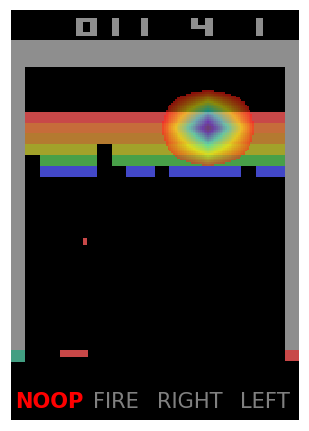

In [138]:
import matplotlib.animation as anim
action_set = ["NOOP","FIRE","RIGHT","LEFT"]

with open('save_image2', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load() 

class AnimatedGif:
    # Initialization
    def __init__(self, size=(640, 480)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 40, size[1] / 40) # To change the final ".GIF" size
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    # Adding the image with 'with_action' option to add action text decision
    def add(self, image, with_action=False, action=''):
        plt_txt = []
        if not with_action :
            plt_im = plt.imshow(image, cmap='Greys', vmin=0, vmax=1, animated=True)
        else :
            # Adding the bottom with futur text on it
            img = np.uint8(np.zeros((210+18, 160, 3)))
            img[:-18] = image
            plt_im = plt.imshow(img, cmap='Greys', vmin=0, vmax=1, animated=True)
            for act in action_set :
                # Plot the 4 "NOOP","FIRE","RIGHT","LEFT" with the chosen one in Bold Red police
                if action == act :
                    plt_txt.append(plt.text(2 + 41 * action_set.index(act)-5*(act=="RIGHT")+1*(act=="Fire"), 220, act, color='r', fontsize=21,fontweight="bold"))
                else :
                    plt_txt.append(plt.text(4 + 41 * action_set.index(act)-5*(act=="RIGHT")+1*(act=="Fire"), 220, act, color='gray', fontsize=21))
        
        self.images.append([plt_im] + plt_txt)
 
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, fps=5) # FPS for frame per second on the final .GIF

### HERE ANIMATION ###
        
with_action = True
        
animated = AnimatedGif(size=(160, 210+18*with_action))
for i in file_result :
    if i > 400 : break
    animated.add(file_result[i]["img"], with_action, action=file_result[i]["action"])

animated.save('Grad-CAM-v3.gif')